# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [4]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [9]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [10]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [11]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [12]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [26]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, batch_size=300, epochs=10, learning_rate=1e-3, reg=1e1)

Epoch 0, loss: 838.319700
Epoch 1, loss: 916.189082
Epoch 2, loss: 836.696416
Epoch 3, loss: 785.672703
Epoch 4, loss: 1066.105670
Epoch 5, loss: 766.849288
Epoch 6, loss: 876.590049
Epoch 7, loss: 888.256254
Epoch 8, loss: 927.901945
Epoch 9, loss: 1072.754783


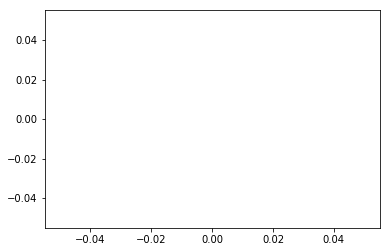

In [23]:
# let's look at the loss history!
plt.plot(loss_history)

In [29]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

[4 0 1 2 1 9 1 1 4 1 0 7 2 3 0 2 5 5 1 3 3 1 3 5 8 2 5 1 5 3 3 2 4 6 5 2 3
 1 2 0 2 1 1 1 2 9 5 2 8 3 3 6 2 1 1 9 1 1 3 2 1 9 8 2 1 9 5 0 1 5 8 2 1 8
 1 2 2 0 3 3 5 2 2 1 1 1 1 5 5 2 1 2 4 4 3 4 1 2 4 2 1 4 8 1 1 4 8 1 6 4 2
 5 1 2 1 3 1 2 4 5 1 2 1 4 1 0 6 3 1 1 1 2 1 1 3 3 6 5 1 2 3 4 6 2 3 2 2 1
 2 1 9 7 2 6 8 5 3 1 0 2 1 4 2 1 5 1 7 1 2 0 1 1 2 6 1 2 1 1 5 0 4 9 2 3 3
 2 9 1 1 1 2 4 7 1 2 2 0 2 1 5 5 6 3 0 8 1 1 4 4 0 2 2 6 6 3 6 2 1 3 7 1 5
 4 3 3 3 3 3 5 3 2 2 1 1 2 0 2 1 2 4 1 2 1 1 5 1 2 2 7 2 2 2 1 4 3 0 0 1 0
 2 1 1 4 4 2 1 9 2 0 5 1 2 1 3 0 8 1 1 3 1 0 1 1 1 7 1 2 8 6 1 8 5 2 2 7 4
 1 1 4 3 8 2 1 1 4 1 4 1 4 1 5 9 0 1 5 7 9 1 4 2 3 1 8 2 1 3 3 9 1 5 9 8 6
 3 1 1 6 4 5 1 9 3 7 9 7 5 6 4 1 3 4 1 1 1 4 1 4 3 2 1 8 5 5 2 0 0 0 1 2 3
 5 5 3 9 2 2 5 1 1 2 2 1 2 4 1 2 1 2 1 4 1 8 2 3 1 4 1 5 8 1 8 7 4 5 2 2 4
 1 4 6 1 7 2 5 1 1 5 4 1 3 6 2 3 4 2 3 1 4 2 2 1 1 3 1 4 4 2 3 1 3 5 2 4 3
 4 5 2 4 1 1 1 1 1 1 3 4 2 3 2 2 1 2 1 1 2 1 1 9 4 1 1 1 7 1 5 6 5 1 2 1 2
 8 3 1 1 1 9 1 3 2 4 1 4 

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [31]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = -1

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size, reg=reg_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
        print(f"Accuracy after training for 100 epochs: {accuracy}")
        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 864.185338
Epoch 1, loss: 939.844769
Epoch 2, loss: 979.351721
Epoch 3, loss: 826.353201
Epoch 4, loss: 749.378453
Epoch 5, loss: 1054.457379
Epoch 6, loss: 888.891941
Epoch 7, loss: 870.077979
Epoch 8, loss: 707.203044
Epoch 9, loss: 729.828428
Epoch 10, loss: 753.940552
Epoch 11, loss: 1036.293958
Epoch 12, loss: 729.471901
Epoch 13, loss: 769.563095
Epoch 14, loss: 945.463914
Epoch 15, loss: 847.063996
Epoch 16, loss: 764.407763
Epoch 17, loss: 678.870246
Epoch 18, loss: 731.736843
Epoch 19, loss: 768.982193
Epoch 20, loss: 717.039217
Epoch 21, loss: 1044.319144
Epoch 22, loss: 814.348210
Epoch 23, loss: 701.257178
Epoch 24, loss: 778.731509
Epoch 25, loss: 796.773570
Epoch 26, loss: 915.810955
Epoch 27, loss: 831.245622
Epoch 28, loss: 739.137105
Epoch 29, loss: 692.267370
Epoch 30, loss: 789.808137
Epoch 31, loss: 755.861729
Epoch 32, loss: 785.711357
Epoch 33, loss: 732.722822
Epoch 34, loss: 802.904023
Epoch 35, loss: 930.353541
Epoch 36, loss: 675.444812
Epoch 37

Epoch 24, loss: 817.308562
Epoch 25, loss: 770.013365
Epoch 26, loss: 693.900184
Epoch 27, loss: 821.936995
Epoch 28, loss: 671.230817
Epoch 29, loss: 871.868291
Epoch 30, loss: 747.176226
Epoch 31, loss: 746.221558
Epoch 32, loss: 747.953957
Epoch 33, loss: 748.385617
Epoch 34, loss: 694.617173
Epoch 35, loss: 869.714277
Epoch 36, loss: 677.095656
Epoch 37, loss: 860.630079
Epoch 38, loss: 735.469195
Epoch 39, loss: 774.941001
Epoch 40, loss: 705.505804
Epoch 41, loss: 858.295474
Epoch 42, loss: 842.493278
Epoch 43, loss: 783.716240
Epoch 44, loss: 646.189557
Epoch 45, loss: 780.623180
Epoch 46, loss: 925.975649
Epoch 47, loss: 734.612756
Epoch 48, loss: 809.048240
Epoch 49, loss: 664.237550
Epoch 50, loss: 684.471653
Epoch 51, loss: 805.387944
Epoch 52, loss: 819.751560
Epoch 53, loss: 744.999436
Epoch 54, loss: 750.335721
Epoch 55, loss: 677.180157
Epoch 56, loss: 822.211005
Epoch 57, loss: 760.634864
Epoch 58, loss: 907.134427
Epoch 59, loss: 809.813626
Epoch 60, loss: 815.598236
E

Epoch 48, loss: 818.886331
Epoch 49, loss: 650.172859
Epoch 50, loss: 773.198028
Epoch 51, loss: 855.993677
Epoch 52, loss: 868.452301
Epoch 53, loss: 777.656042
Epoch 54, loss: 760.693252
Epoch 55, loss: 714.719360
Epoch 56, loss: 635.892502
Epoch 57, loss: 834.426014
Epoch 58, loss: 696.814241
Epoch 59, loss: 644.670385
Epoch 60, loss: 690.706213
Epoch 61, loss: 700.684023
Epoch 62, loss: 785.735136
Epoch 63, loss: 776.645617
Epoch 64, loss: 915.680450
Epoch 65, loss: 691.177705
Epoch 66, loss: 813.109078
Epoch 67, loss: 853.013478
Epoch 68, loss: 633.303716
Epoch 69, loss: 714.315001
Epoch 70, loss: 755.160417
Epoch 71, loss: 800.120009
Epoch 72, loss: 727.184481
Epoch 73, loss: 813.046811
Epoch 74, loss: 934.307530
Epoch 75, loss: 756.945155
Epoch 76, loss: 761.078888
Epoch 77, loss: 597.516021
Epoch 78, loss: 909.085161
Epoch 79, loss: 702.684645
Epoch 80, loss: 906.712644
Epoch 81, loss: 754.785166
Epoch 82, loss: 812.378843
Epoch 83, loss: 710.966646
Epoch 84, loss: 907.856604
E

Epoch 72, loss: 648.320053
Epoch 73, loss: 629.865559
Epoch 74, loss: 620.157368
Epoch 75, loss: 648.721710
Epoch 76, loss: 636.169361
Epoch 77, loss: 646.587632
Epoch 78, loss: 628.495304
Epoch 79, loss: 643.660960
Epoch 80, loss: 636.780847
Epoch 81, loss: 641.150478
Epoch 82, loss: 637.780106
Epoch 83, loss: 626.235846
Epoch 84, loss: 636.287092
Epoch 85, loss: 618.345316
Epoch 86, loss: 625.605543
Epoch 87, loss: 649.123393
Epoch 88, loss: 642.643777
Epoch 89, loss: 636.811393
Epoch 90, loss: 620.127484
Epoch 91, loss: 625.540202
Epoch 92, loss: 643.119374
Epoch 93, loss: 624.055191
Epoch 94, loss: 632.173813
Epoch 95, loss: 628.774331
Epoch 96, loss: 635.293220
Epoch 97, loss: 630.819263
Epoch 98, loss: 634.013756
Epoch 99, loss: 627.303135
Epoch 100, loss: 644.089257
Epoch 101, loss: 629.762890
Epoch 102, loss: 624.442923
Epoch 103, loss: 610.936146
Epoch 104, loss: 624.708309
Epoch 105, loss: 602.929695
Epoch 106, loss: 610.207214
Epoch 107, loss: 645.743472
Epoch 108, loss: 608

Epoch 96, loss: 637.707935
Epoch 97, loss: 640.723036
Epoch 98, loss: 637.218785
Epoch 99, loss: 612.753881
Epoch 100, loss: 633.545489
Epoch 101, loss: 616.328161
Epoch 102, loss: 610.419631
Epoch 103, loss: 632.256295
Epoch 104, loss: 626.841575
Epoch 105, loss: 627.026836
Epoch 106, loss: 623.647813
Epoch 107, loss: 623.619938
Epoch 108, loss: 601.299445
Epoch 109, loss: 646.917245
Epoch 110, loss: 621.075717
Epoch 111, loss: 630.258876
Epoch 112, loss: 622.881710
Epoch 113, loss: 623.359420
Epoch 114, loss: 623.464367
Epoch 115, loss: 628.343618
Epoch 116, loss: 629.192252
Epoch 117, loss: 620.598696
Epoch 118, loss: 619.697708
Epoch 119, loss: 639.925873
Epoch 120, loss: 622.368361
Epoch 121, loss: 640.406370
Epoch 122, loss: 630.663140
Epoch 123, loss: 644.463482
Epoch 124, loss: 627.384901
Epoch 125, loss: 625.656620
Epoch 126, loss: 648.266491
Epoch 127, loss: 611.700193
Epoch 128, loss: 606.687419
Epoch 129, loss: 621.377760
Epoch 130, loss: 612.824479
Epoch 131, loss: 631.221

Epoch 119, loss: 606.778730
Epoch 120, loss: 619.688558
Epoch 121, loss: 634.207334
Epoch 122, loss: 613.272659
Epoch 123, loss: 630.123664
Epoch 124, loss: 626.757574
Epoch 125, loss: 634.644860
Epoch 126, loss: 623.906974
Epoch 127, loss: 609.402019
Epoch 128, loss: 611.618247
Epoch 129, loss: 603.644118
Epoch 130, loss: 617.801144
Epoch 131, loss: 622.751871
Epoch 132, loss: 604.023299
Epoch 133, loss: 618.485738
Epoch 134, loss: 637.035078
Epoch 135, loss: 625.185793
Epoch 136, loss: 616.629272
Epoch 137, loss: 644.105800
Epoch 138, loss: 610.726853
Epoch 139, loss: 629.468210
Epoch 140, loss: 601.864300
Epoch 141, loss: 627.301270
Epoch 142, loss: 621.776516
Epoch 143, loss: 614.599581
Epoch 144, loss: 630.817773
Epoch 145, loss: 628.070891
Epoch 146, loss: 624.087034
Epoch 147, loss: 635.746555
Epoch 148, loss: 635.655519
Epoch 149, loss: 617.776131
Epoch 150, loss: 606.222582
Epoch 151, loss: 622.417374
Epoch 152, loss: 634.406815
Epoch 153, loss: 614.951839
Epoch 154, loss: 631

Epoch 142, loss: 654.177109
Epoch 143, loss: 642.901994
Epoch 144, loss: 642.306169
Epoch 145, loss: 653.049583
Epoch 146, loss: 649.101110
Epoch 147, loss: 639.244322
Epoch 148, loss: 654.806011
Epoch 149, loss: 648.322942
Epoch 150, loss: 647.046138
Epoch 151, loss: 645.060713
Epoch 152, loss: 655.181365
Epoch 153, loss: 648.259110
Epoch 154, loss: 652.647672
Epoch 155, loss: 643.984405
Epoch 156, loss: 651.816377
Epoch 157, loss: 642.516106
Epoch 158, loss: 650.725795
Epoch 159, loss: 647.751097
Epoch 160, loss: 649.670510
Epoch 161, loss: 666.442310
Epoch 162, loss: 647.387599
Epoch 163, loss: 648.234685
Epoch 164, loss: 633.785914
Epoch 165, loss: 656.069257
Epoch 166, loss: 637.588895
Epoch 167, loss: 641.426603
Epoch 168, loss: 654.868374
Epoch 169, loss: 641.639100
Epoch 170, loss: 654.732802
Epoch 171, loss: 644.055608
Epoch 172, loss: 652.398488
Epoch 173, loss: 651.854141
Epoch 174, loss: 646.224804
Epoch 175, loss: 651.315727
Epoch 176, loss: 657.864001
Epoch 177, loss: 653

Epoch 166, loss: 653.651790
Epoch 167, loss: 646.237494
Epoch 168, loss: 649.636392
Epoch 169, loss: 651.159705
Epoch 170, loss: 633.652122
Epoch 171, loss: 652.604270
Epoch 172, loss: 637.164099
Epoch 173, loss: 624.900960
Epoch 174, loss: 663.490538
Epoch 175, loss: 643.235753
Epoch 176, loss: 637.759362
Epoch 177, loss: 650.840294
Epoch 178, loss: 641.938816
Epoch 179, loss: 647.414977
Epoch 180, loss: 626.649503
Epoch 181, loss: 641.756137
Epoch 182, loss: 642.772107
Epoch 183, loss: 651.260906
Epoch 184, loss: 638.195701
Epoch 185, loss: 644.277857
Epoch 186, loss: 659.451314
Epoch 187, loss: 650.337696
Epoch 188, loss: 646.070861
Epoch 189, loss: 636.247775
Epoch 190, loss: 653.210903
Epoch 191, loss: 649.862134
Epoch 192, loss: 636.213159
Epoch 193, loss: 645.617070
Epoch 194, loss: 656.252648
Epoch 195, loss: 638.310375
Epoch 196, loss: 656.154136
Epoch 197, loss: 652.785378
Epoch 198, loss: 642.614642
Epoch 199, loss: 641.595388
[1 1 1 2 1 2 1 1 1 1 3 1 2 4 4 2 1 1 1 2 1 1 1 1

Epoch 190, loss: 639.505208
Epoch 191, loss: 646.907157
Epoch 192, loss: 648.801688
Epoch 193, loss: 646.304972
Epoch 194, loss: 635.317470
Epoch 195, loss: 644.170148
Epoch 196, loss: 653.294310
Epoch 197, loss: 629.438419
Epoch 198, loss: 636.737708
Epoch 199, loss: 649.353583
[1 1 1 2 1 2 1 1 1 1 3 1 2 4 4 2 1 1 1 2 1 1 1 1 3 1 2 1 1 1 3 1 1 2 1 1 1
 2 1 0 2 1 1 1 3 1 2 1 3 2 1 1 1 1 3 1 1 1 3 2 1 1 2 2 1 1 1 4 1 1 1 1 1 2
 2 1 2 1 1 1 1 2 2 1 2 1 1 3 3 1 1 3 1 1 4 1 1 2 1 2 1 4 2 1 1 1 2 1 2 1 2
 4 3 1 1 2 1 1 4 1 2 2 1 1 1 1 6 1 1 1 1 2 1 1 1 3 2 1 1 2 3 1 2 1 3 3 1 1
 2 1 0 1 1 2 1 5 3 2 1 1 1 1 1 2 1 1 1 3 2 2 1 1 1 1 1 2 2 1 1 1 4 1 2 1 1
 2 3 1 1 1 2 3 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 2 1 2 1 1 1 2 2 1 1 3 1 2 1
 1 2 1 1 1 1 1 2 2 1 2 1 3 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 3 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 1 3 1 1 2 1 1 1 1 1 2 1 2 1 2 5 2 3 1 1 4 2
 3 1 2 1 2 3 2 1 1 1 1 1 4 1 1 1 1 2 1 1 2 1 1 1 3 1 2 2 1 5 3 1 1 2 1 3 5
 1 1 1 1 1 1 1 7 1 1 2 1 3 3 1 1 1 1 1 1 1 1 

# Какой же точности мы добились на тестовых данных?

In [32]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

[1 2 1 2 1 2 1 8 1 4 7 1 2 1 2 2 1 1 1 4 1 4 2 1 1 4 1 2 2 1 1 1 4 2 5 4 1
 1 0 1 3 5 4 4 6 1 2 1 1 2 1 3 2 1 2 2 2 1 0 1 3 1 6 1 2 1 1 3 1 4 1 2 2 0
 7 1 0 1 2 0 1 4 1 1 1 5 1 2 5 0 2 8 2 1 4 3 2 5 6 2 1 1 3 5 1 1 1 1 1 9 3
 2 2 2 2 6 1 1 8 3 1 1 0 2 1 1 1 2 5 1 1 3 1 2 0 1 3 1 2 3 3 1 2 1 2 1 1 3
 1 2 1 1 1 1 2 1 2 2 1 1 2 2 5 4 2 3 2 1 2 5 6 1 1 2 4 8 1 1 1 1 2 5 1 2 3
 1 1 1 1 1 1 1 3 2 3 3 3 1 2 4 1 2 1 5 2 9 1 3 2 0 7 1 1 1 1 9 2 2 4 6 7 1
 5 1 2 0 1 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 5 3 2 2 2 6 1 1 2 2 2 8 2 1 1 3 3
 2 1 1 1 1 1 5 1 1 4 9 9 5 2 3 5 2 2 4 2 7 1 6 5 1 0 5 1 1 3 2 5 4 1 3 9 5
 3 2 1 5 2 3 2 1 9 5 1 9 1 1 2 8 2 7 6 1 2 1 1 9 1 4 4 6 1 1 3 5 2 1 1 2 2
 1 6 1 3 2 1 1 1 1 1 7 8 4 1 1 1 1 2 1 1 1 2 5 1 1 1 1 1 2 5 1 1 1 9 9 8 4
 1 1 1 3 7 2 2 1 1 1 1 3 1 1 3 1 1 1 1 1 4 1 1 5 1 3 1 9 1 5 3 1 4 1 2 2 1
 1 1 3 1 2 1 2 1 1 3 1 2 1 1 2 1 1 1 1 1 4 8 1 2 1 1 2 1 0 4 5 0 1 3 1 1 1
 1 2 1 2 7 2 1 1 1 1 2 1 3 7 2 1 1 2 2 3 4 1 2 3 1 1 1 1 1 3 2 1 2 1 4 2 3
 7 2 1 1 5 1 1 1 3 2 2 1 